In [1]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import random
import time



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#User input for algorithm:
#for synthetic data/potentially for regular datasets user can set the total subgroups/centroids
centroids = input("Enter number of centroids: ")
groups = input("Enter number of groups: ")

Enter number of centroids: 15
Enter number of groups: 5


In [3]:
#calculates euclidean distance between points
def calc_dist(x,y,x_ref,y_ref):
  return np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 


In [4]:
#calculuates loss by inputting euclidean distance into sigmoid function
def calc_loss(x,y,x_ref,y_ref):
    # calculate Euclidean distance btw person & centroid
    distance = calc_dist(x,y,x_ref,y_ref)
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-1*distance)) #converts distances to probability distribution
    #return loss
    return loss

In [5]:
#this function calculates the summation of all the individual losses within each cluster for minimizing the objective function
def sum_loss(df, centroids, subgroup_loss):
  #total datapoints
  tot_len = 0
  #sum of all individual losses between clusters
  loss_sum = 0
  clusters = []
  max_val = df['min_loss'].max()
  min_val = df['min_loss'].min()

  for i in centroids.keys():
    temp = df[df['min_centr']==i]
    temp = temp.reset_index()
    clusters.append(temp)
    tot_len += len(temp)
    loss_sum += temp['min_loss'].sum()
  print('indiv loss ', (loss_sum/tot_len))
  print('subgroup loss: ', subgroup_loss)
  tot_loss = (loss_sum/tot_len)*(max_val-min_val)
  tot_loss += subgroup_loss
  print('indiv loss ', tot_loss)
  print('subgroup loss: ', subgroup_loss)
  return tot_loss


In [6]:
def assign_cluster(df, centroids):
  start = time.time()
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
    df['dist_from_{}'.format(i)] = calc_dist(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]
  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_{}'.format(i) for i in centroids.keys()]].min(axis=1)
  end = time.time()
  print('Time elapsed Assignment Step: ', end - start)
  for i in range(len(centroids)):
    # del df['loss_from_{}'.format(i)]
    lst = df['min_centr'].unique()
    if i not in lst:
      del df['dist_from_{}'.format(i)]
  return df

In [7]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    percentile_loss = []
    for s in select_group:
        s.sort_values(by=['min_loss'])
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = stats.scoreatpercentile(subgroup, percentile) # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss    
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    return np.abs(difference)

In [8]:
#calculates gradient for clusters
def update_weights(clust, lr, centr, df):
  #total number of points in cluster 0 (points nearest to centroid 0)
  new_centr_x, new_centr_y = centr[0], centr[1]
  #calculate partial derivatives of euclidean distance functions
  x = clust['x_coord']
  y = clust['y_coord']
  center = clust['min_centr']
  distance = clust['dist_from_{}'.format(int(center))]
  grad_x = (np.exp(-1*distance) * (x - centr[0])) / (1 + np.exp(-1*distance)*distance)
  grad_y = (np.exp(-1*distance) * (y - centr[1])) / (1 + np.exp(-1*distance)*distance)
  new_centr_x -= (grad_x) * lr
  new_centr_y -= (grad_y) * lr
  return (new_centr_x, new_centr_y)

In [9]:
def mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1):
  # samp = groups[cdf1].sample(n=b, random_state=1)
  samp = df.sample(n=b, random_state=1)
  samp = samp.reset_index()
  start = time.time()
  # print(samp['min_centr'])
  for i in centroids.keys():
    count[i] = 0
  for s in range(len(samp)):
    clust = samp.iloc[s]['min_centr']
    clust = int(clust)
    count[clust]+=1
    lr = 1/count[clust]
    temp = update_weights(samp.iloc[s], lr, temp_centroids[clust], df)
    temp_centroids[clust] = temp
  end = time.time()
  print('Time elapsed Batch Step: ', end - start)
  return temp_centroids

In [10]:
#updates centroid locations based on gradient descent and loss constraint
def update(perc, centroids, df, subgroup_loss, loss, groups, cdf1):
  tot_loss_lst = []
  b = 1000
  max_iter = 50
  iter_num = 0
  conv = 3
  j = 0
  tot_loss_lst.append(loss)
  L = perc * subgroup_loss
  print('L: ', L)
  #set temporary centroids for assignment
  temp_centroids = {}
  for i in centroids.keys():
    temp_centroids[i] = centroids[i]
  count = {}
  #beginning of updating 
  # while subgroup_loss > L and iter_num < max_iter:
  while iter_num < max_iter:
    start = time.time()
    old_loss = loss
    #set up for mini batch gradient descent
    temp_centroids = mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1)
    #testing to see if new centroid locations improve summation of individual loss
    temp_df = assign_cluster(df, temp_centroids)
    groups = compute_groups(temp_df)
    cdf1, cdf2 = compute_cdf(groups)
    temp_subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)   
    temp_loss = sum_loss(temp_df, temp_centroids, temp_subgroup_loss)
    iter_num += 1
    print('iteration number: ', iter_num)
    print('old loss: ', old_loss)
    print('temp loss: ', temp_loss)
    if old_loss != temp_loss and j < conv:
      #only change centroid locations if it improves subgroup loss
      if old_loss > temp_loss:
        subgroup_loss = temp_subgroup_loss
        loss = temp_loss
        df = temp_df
        groups = compute_groups(df)
        compute_cdf_graph(groups)
        for i in centroids.keys():
          if temp_centroids[i] != 0:
            centroids[i] = temp_centroids[i]

        fig = plt.figure(figsize=(5,5))
        ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

        for i in centroids.keys():
          plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])

        plt.xlim(0, 20)
        plt.ylim(0, 20)
        ax.set_title("Synthetic Data")
        plt.show()
      else:
        j += 1
      # loss = sum_loss(temp_df, centroids, subgroup_loss)
      tot_loss_lst.append(loss)
    else:
      end = time.time()
      print('Time elapsed End of Update Step: ', end - start)
      plt.title('Cost per iteration')
      plt.plot(tot_loss_lst)
      plt.show()
      return centroids
  plt.title('Cost per iteration')
  plt.plot(tot_loss_lst)
  plt.show()
  print('Reached max iterations')
  return centroids    

In [11]:
def compute_cdf(groups):
  lst = []
  perc = []
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    lst.append(sorted_data['min_loss'].sum())
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    perc.append(stats.scoreatpercentile(subgroup, 50))
  min_ind = perc.index(min(perc))
  max_ind = perc.index(max(perc))
  return (max_ind, min_ind)

In [12]:
def compute_cdf_graph(groups):
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    plt.plot(sorted_data['min_loss'], yvals)
  plt.xlabel('loss per individual')
  plt.ylabel('% of people within certain loss of centroid')
  plt.title('Individual loss- CDF stratified by group')
  plt.show()

In [13]:
def compute_groups(df):
  num_groups = df.group.nunique()
  groups = []
  for i in range(num_groups):
    group = df[df['group']==i]
    group = group.reset_index()
    groups.append(group)
  return groups

In [14]:
def compute_clusters(df):
  num_clusters = df.min_centr.nunique()
  clusters = []
  for i in range(num_clusters):
    cluster = df[df['min_centr']==i]
    cluster = cluster.reset_index()
    clusters.append(cluster)
  return clusters

Time elapsed Assignment Step:  2.7787117958068848


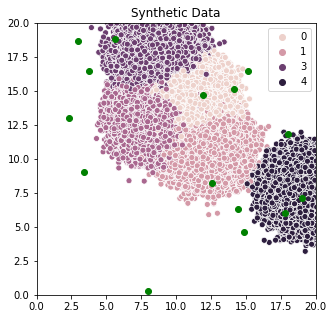

{0: (19.00699226568221, 7.132651555117125),
 1: (5.630373789274506, 18.79096796716362),
 2: (12.549133938498375, 8.259528977756755),
 3: (14.183246532534252, 15.129452087723717),
 4: (18.047226896677532, 11.836102444733656),
 5: (3.7683516830273356, 16.457013758153035),
 6: (2.9366003951751263, 18.69689110744411),
 7: (3.421587009359046, 9.028570379197765),
 8: (11.927321542158092, 14.720225344197711),
 9: (17.83254597542132, 5.999570472249609),
 10: (2.317336088110813, 12.999333073782395),
 11: (15.191384632037382, 16.460045113288494),
 12: (14.904879030039968, 4.632941207739241),
 13: (14.464018853683761, 6.322611514305791),
 14: (7.983031598981263, 0.3093717210860514)}

In [15]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification


# Generate Imbalanced Synthetic Data
# X,y = make_classification(n_samples=800000, n_classes=6,shift=4 ,n_informative=4, n_redundant=0,n_repeated=0, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.5,.1,.1, .5, .15, .1], random_state=55)
center_box = (0,20)
X, y = make_blobs(n_samples=800000, centers=int(groups), n_features=2,center_box=center_box,random_state=0)
# create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]})
df['group'] = y


#arbitrarily picked random k (number of centroids)
k = int(centroids)
centroids = {}
#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
for i in range(k):
  centroids[i] = ((random.uniform(0,20)), (random.uniform(0,20)))
#colors for centroids
color_map = {}
for i in range(k):
  color_map[i] = 'g'

#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
df = assign_cluster(df, centroids)
df
plt.xlim(0, 20)
plt.ylim(0, 20)
ax.set_title("Synthetic Data")
plt.show()

centroids

Time elapsed Assignment Step:  2.8250744342803955


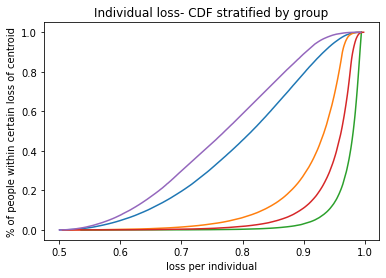

indiv loss  0.8791902036224748
subgroup loss:  0.2096902061367808
indiv loss  0.6468160436049883
subgroup loss:  0.2096902061367808
L:  0.14678314429574654
Time elapsed Batch Step:  0.4298367500305176
Time elapsed Assignment Step:  2.712104558944702
indiv loss  0.9532329644042745
subgroup loss:  0.05785733578294361
indiv loss  0.530249727758406
subgroup loss:  0.05785733578294361
iteration number:  1
old loss:  0.6468160436049883
temp loss:  0.530249727758406


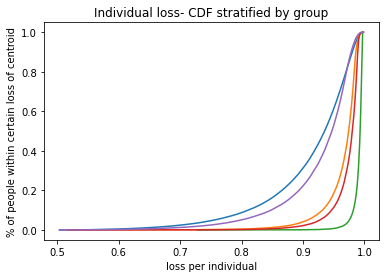

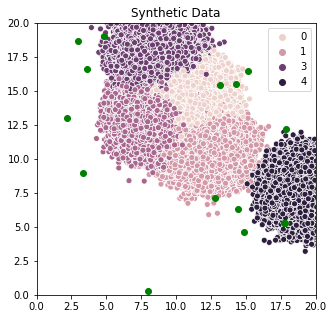

Time elapsed Batch Step:  0.43248939514160156
Time elapsed Assignment Step:  2.737502098083496
indiv loss  0.9719586247217633
subgroup loss:  0.02870014024283707
indiv loss  0.5046509918080131
subgroup loss:  0.02870014024283707
iteration number:  2
old loss:  0.530249727758406
temp loss:  0.5046509918080131


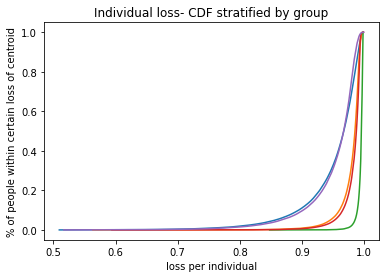

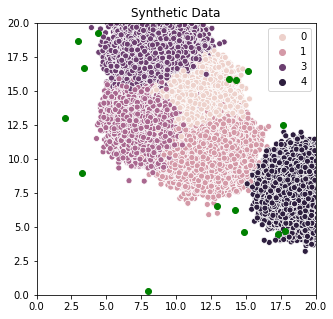

Time elapsed Batch Step:  0.4264047145843506
Time elapsed Assignment Step:  2.7823646068573
indiv loss  0.9805248672452967
subgroup loss:  0.019822720648235537
indiv loss  0.4938448533092107
subgroup loss:  0.019822720648235537
iteration number:  3
old loss:  0.5046509918080131
temp loss:  0.4938448533092107


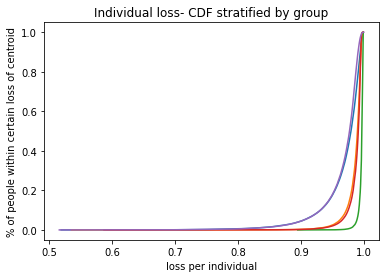

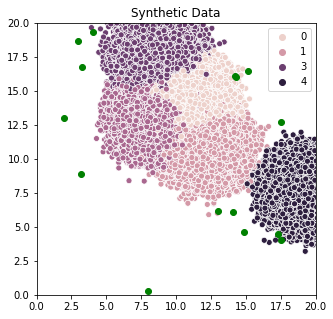

Time elapsed Batch Step:  0.467487096786499
Time elapsed Assignment Step:  2.7320821285247803
indiv loss  0.9850866969206353
subgroup loss:  0.013861287384700938
indiv loss  0.4861259551054278
subgroup loss:  0.013861287384700938
iteration number:  4
old loss:  0.4938448533092107
temp loss:  0.4861259551054278


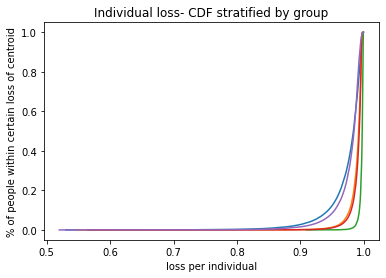

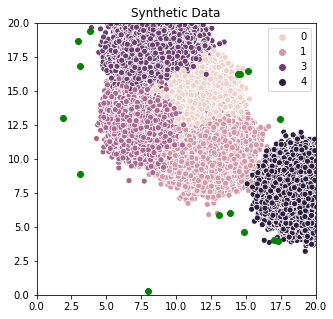

Time elapsed Batch Step:  0.44072914123535156
Time elapsed Assignment Step:  2.841228485107422
indiv loss  0.988157704635959
subgroup loss:  0.010195373610146996
indiv loss  0.4716062673982064
subgroup loss:  0.010195373610146996
iteration number:  5
old loss:  0.4861259551054278
temp loss:  0.4716062673982064


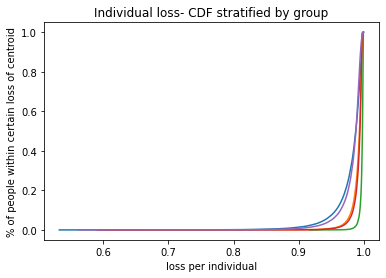

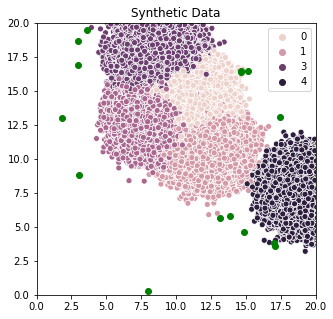

Time elapsed Batch Step:  0.43662166595458984
Time elapsed Assignment Step:  2.8036837577819824
indiv loss  0.9900628709606425
subgroup loss:  0.008546183865616008
indiv loss  0.48572555657853067
subgroup loss:  0.008546183865616008
iteration number:  6
old loss:  0.4716062673982064
temp loss:  0.48572555657853067
Time elapsed Batch Step:  0.4326050281524658
Time elapsed Assignment Step:  2.7273454666137695
indiv loss  0.990969390983834
subgroup loss:  0.007731496090527035
indiv loss  0.48012048174792277
subgroup loss:  0.007731496090527035
iteration number:  7
old loss:  0.4716062673982064
temp loss:  0.48012048174792277
Time elapsed Batch Step:  0.4312705993652344
Time elapsed Assignment Step:  2.7156476974487305
indiv loss  0.9921280489264378
subgroup loss:  0.0064583490916807484
indiv loss  0.4367857667241119
subgroup loss:  0.0064583490916807484
iteration number:  8
old loss:  0.4716062673982064
temp loss:  0.4367857667241119


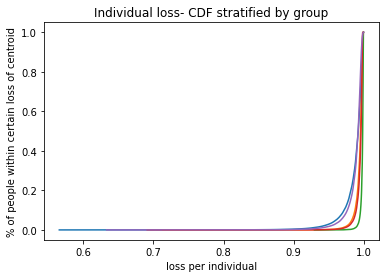

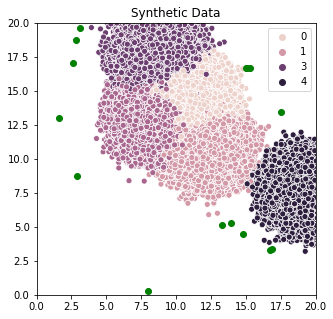

Time elapsed Batch Step:  0.4201042652130127
Time elapsed Assignment Step:  2.731954336166382
indiv loss  0.9927149536485138
subgroup loss:  0.0062224358354024956
indiv loss  0.42994096592943865
subgroup loss:  0.0062224358354024956
iteration number:  9
old loss:  0.4367857667241119
temp loss:  0.42994096592943865


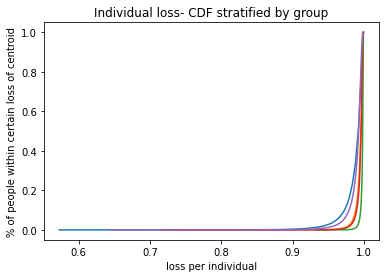

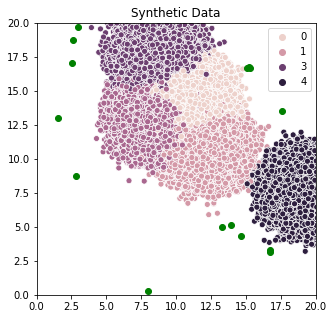

Time elapsed Batch Step:  0.4423058032989502
Time elapsed Assignment Step:  2.6576125621795654
indiv loss  0.9935250948956927
subgroup loss:  0.005245934082385495
indiv loss  0.39123512940799576
subgroup loss:  0.005245934082385495
iteration number:  10
old loss:  0.42994096592943865
temp loss:  0.39123512940799576


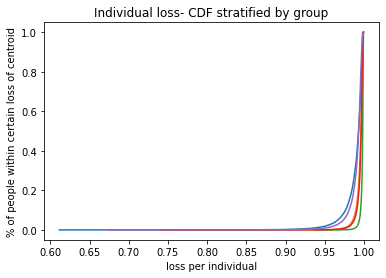

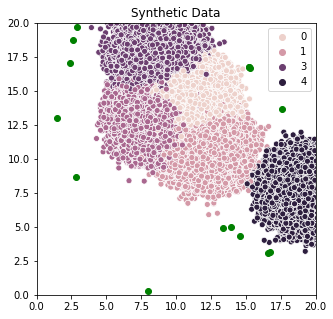

Time elapsed Batch Step:  0.43221569061279297
Time elapsed Assignment Step:  2.7212812900543213
indiv loss  0.9939361049641203
subgroup loss:  0.005150344186871658
indiv loss  0.38546985352230523
subgroup loss:  0.005150344186871658
iteration number:  11
old loss:  0.39123512940799576
temp loss:  0.38546985352230523


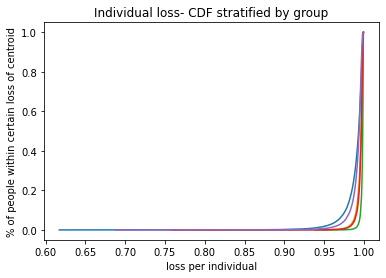

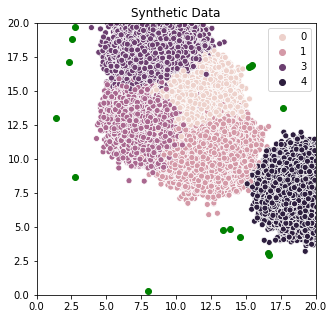

Time elapsed Batch Step:  0.4245021343231201
Time elapsed Assignment Step:  2.842092752456665
indiv loss  0.9945276219978814
subgroup loss:  0.004440160946022287
indiv loss  0.35327575732477834
subgroup loss:  0.004440160946022287
iteration number:  12
old loss:  0.38546985352230523
temp loss:  0.35327575732477834


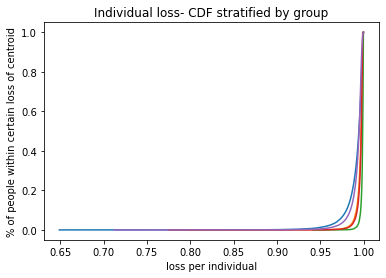

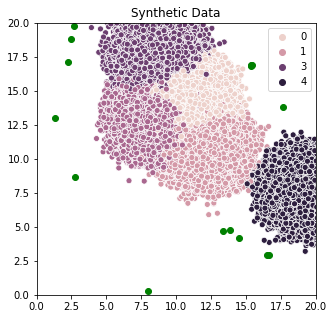

Time elapsed Batch Step:  0.4303748607635498
Time elapsed Assignment Step:  2.9219136238098145
indiv loss  0.9948400385434407
subgroup loss:  0.0043607702724954844
indiv loss  0.34789517780473705
subgroup loss:  0.0043607702724954844
iteration number:  13
old loss:  0.35327575732477834
temp loss:  0.34789517780473705


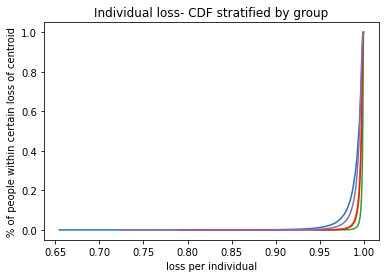

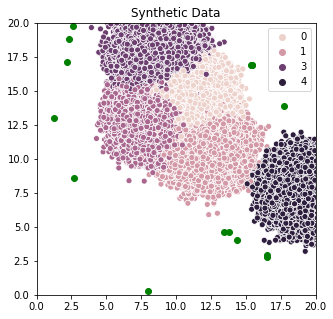

Time elapsed Batch Step:  0.43022847175598145
Time elapsed Assignment Step:  2.745020627975464
indiv loss  0.995258067505614
subgroup loss:  0.0038978848113218056
indiv loss  0.32434354906856855
subgroup loss:  0.0038978848113218056
iteration number:  14
old loss:  0.34789517780473705
temp loss:  0.32434354906856855


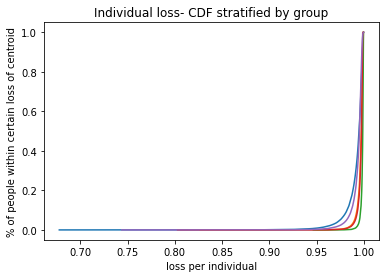

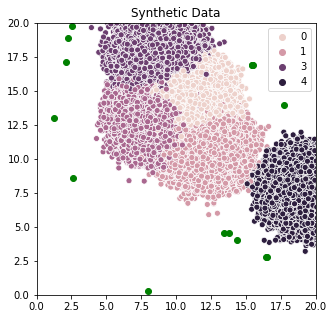

Time elapsed Batch Step:  0.4190993309020996
Time elapsed Assignment Step:  2.7710022926330566
indiv loss  0.9954862464698762
subgroup loss:  0.0038629430380822116
indiv loss  0.32066937239688675
subgroup loss:  0.0038629430380822116
iteration number:  15
old loss:  0.32434354906856855
temp loss:  0.32066937239688675


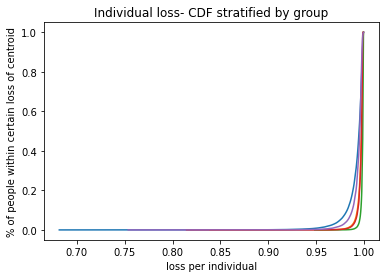

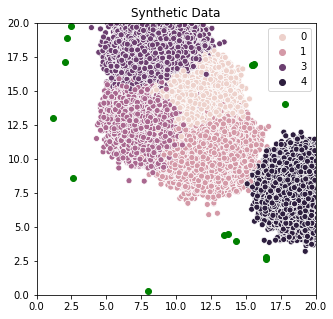

Time elapsed Batch Step:  0.4250028133392334
Time elapsed Assignment Step:  2.7544503211975098
indiv loss  0.9956872716424273
subgroup loss:  0.003801101056738143
indiv loss  0.3160727169370875
subgroup loss:  0.003801101056738143
iteration number:  16
old loss:  0.32066937239688675
temp loss:  0.3160727169370875


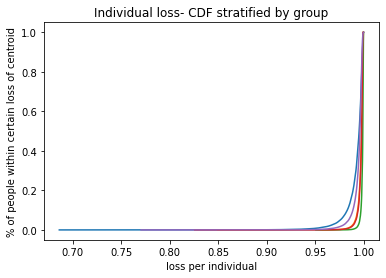

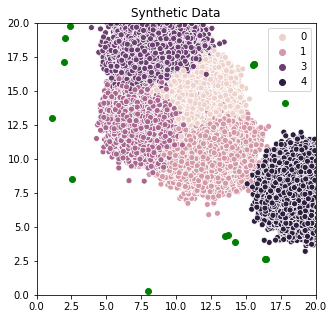

Time elapsed Batch Step:  0.4272282123565674
Time elapsed Assignment Step:  2.7114741802215576
indiv loss  0.9960082287254445
subgroup loss:  0.0034340165265103195
indiv loss  0.2959371255486949
subgroup loss:  0.0034340165265103195
iteration number:  17
old loss:  0.3160727169370875
temp loss:  0.2959371255486949


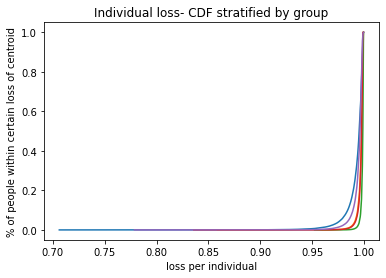

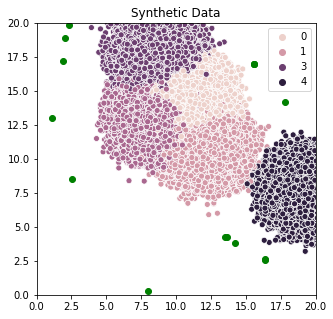

Time elapsed Batch Step:  0.48145055770874023
Time elapsed Assignment Step:  2.7702229022979736
indiv loss  0.9961766172814469
subgroup loss:  0.003409319221969742
indiv loss  0.29296135036411003
subgroup loss:  0.003409319221969742
iteration number:  18
old loss:  0.2959371255486949
temp loss:  0.29296135036411003


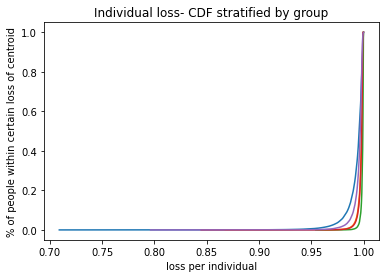

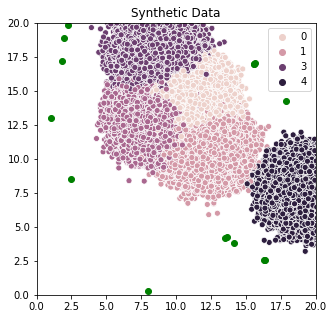

Time elapsed Batch Step:  0.45093536376953125
Time elapsed Assignment Step:  2.772876501083374
indiv loss  0.9963119118103605
subgroup loss:  0.0033605821351210263
indiv loss  0.2891113052944843
subgroup loss:  0.0033605821351210263
iteration number:  19
old loss:  0.29296135036411003
temp loss:  0.2891113052944843


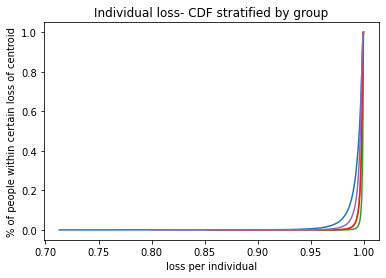

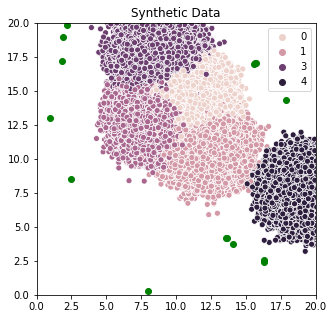

Time elapsed Batch Step:  0.4281351566314697
Time elapsed Assignment Step:  2.7349119186401367
indiv loss  0.9965661231753077
subgroup loss:  0.003063888046530794
indiv loss  0.2716506247731242
subgroup loss:  0.003063888046530794
iteration number:  20
old loss:  0.2891113052944843
temp loss:  0.2716506247731242


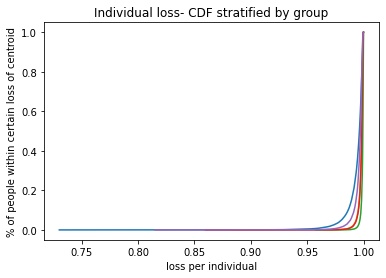

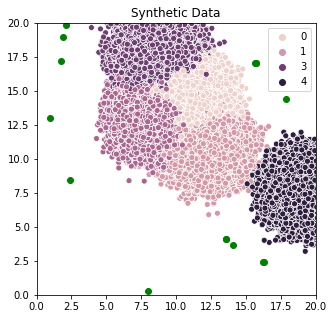

Time elapsed Batch Step:  0.43149590492248535
Time elapsed Assignment Step:  2.772580862045288
indiv loss  0.9966683376957681
subgroup loss:  0.0030433736842125914
indiv loss  0.2691446204696304
subgroup loss:  0.0030433736842125914
iteration number:  21
old loss:  0.2716506247731242
temp loss:  0.2691446204696304


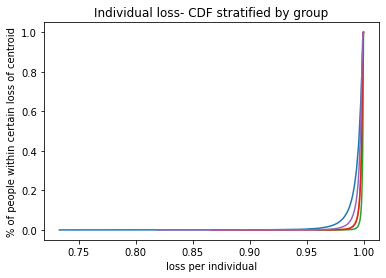

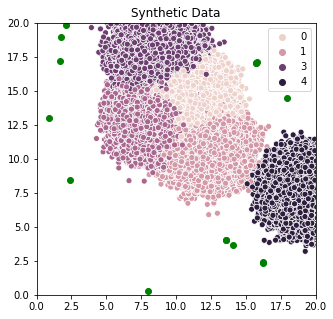

Time elapsed Batch Step:  0.42436742782592773
Time elapsed Assignment Step:  2.737032413482666
indiv loss  0.9967839945943217
subgroup loss:  0.0030093351525347645
indiv loss  0.26609341668062403
subgroup loss:  0.0030093351525347645
iteration number:  22
old loss:  0.2691446204696304
temp loss:  0.26609341668062403


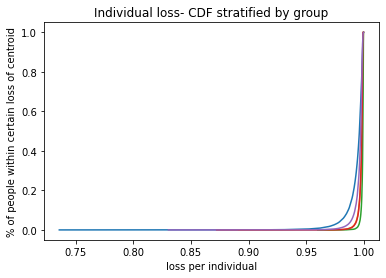

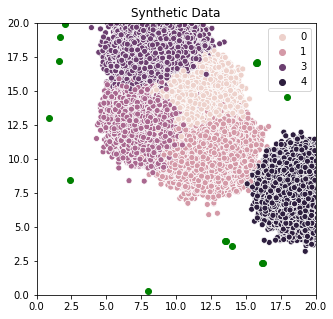

Time elapsed Batch Step:  0.43124961853027344
Time elapsed Assignment Step:  2.68891978263855
indiv loss  0.9969705981031723
subgroup loss:  0.0027584081026316154
indiv loss  0.25060993418156147
subgroup loss:  0.0027584081026316154
iteration number:  23
old loss:  0.26609341668062403
temp loss:  0.25060993418156147


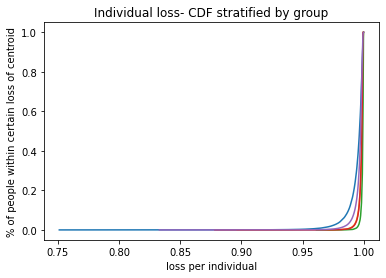

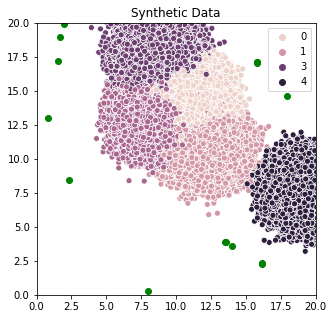

Time elapsed Batch Step:  0.42843127250671387
Time elapsed Assignment Step:  2.7154300212860107
indiv loss  0.9970614110424447
subgroup loss:  0.0027464168618325235
indiv loss  0.24869163431946784
subgroup loss:  0.0027464168618325235
iteration number:  24
old loss:  0.25060993418156147
temp loss:  0.24869163431946784


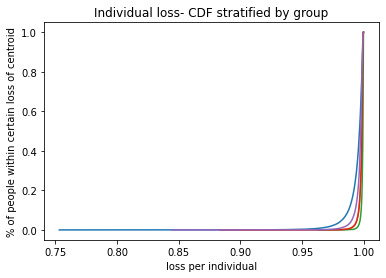

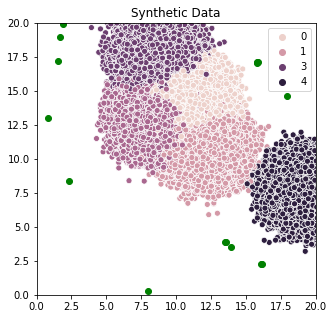

Time elapsed Batch Step:  0.42839884757995605
Time elapsed Assignment Step:  2.8852357864379883
indiv loss  0.9971403966223993
subgroup loss:  0.00271698140008092
indiv loss  0.24601981629787387
subgroup loss:  0.00271698140008092
iteration number:  25
old loss:  0.24869163431946784
temp loss:  0.24601981629787387


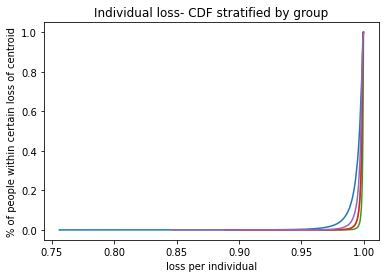

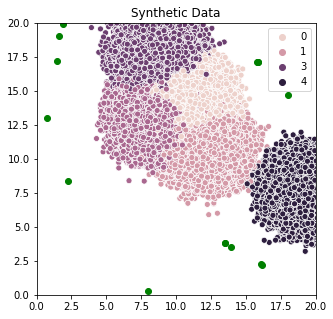

Time elapsed Batch Step:  0.4304385185241699
Time elapsed Assignment Step:  2.7672119140625
indiv loss  0.9973040830366012
subgroup loss:  0.0025074478605754402
indiv loss  0.2324540059366684
subgroup loss:  0.0025074478605754402
iteration number:  26
old loss:  0.24601981629787387
temp loss:  0.2324540059366684


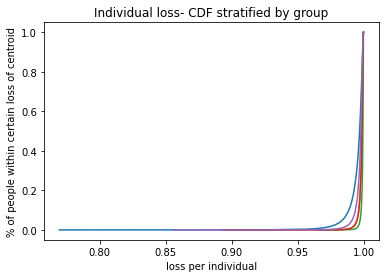

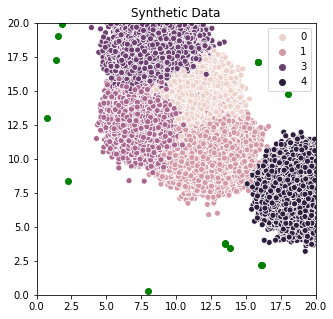

Time elapsed Batch Step:  0.4249889850616455
Time elapsed Assignment Step:  2.7432475090026855
indiv loss  0.9973666303816979
subgroup loss:  0.002497311650122458
indiv loss  0.23076499094435318
subgroup loss:  0.002497311650122458
iteration number:  27
old loss:  0.2324540059366684
temp loss:  0.23076499094435318


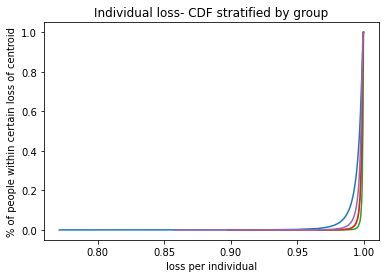

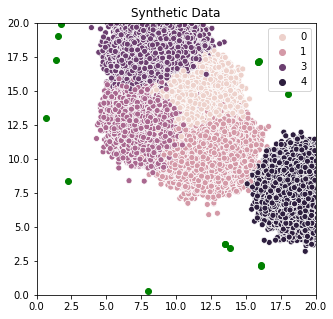

Time elapsed Batch Step:  0.43436479568481445
Time elapsed Assignment Step:  2.7123043537139893
indiv loss  0.9974382746436066
subgroup loss:  0.0024743924333889833
indiv loss  0.22858721853465006
subgroup loss:  0.0024743924333889833
iteration number:  28
old loss:  0.23076499094435318
temp loss:  0.22858721853465006


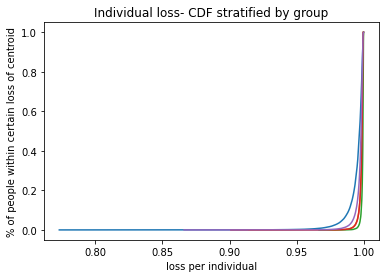

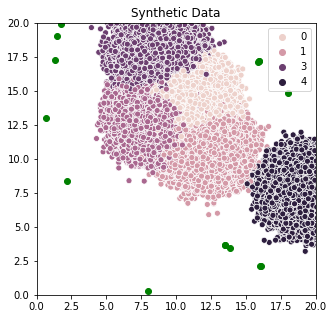

Time elapsed Batch Step:  0.4281196594238281
Time elapsed Assignment Step:  2.704716920852661
indiv loss  0.9975672408491851
subgroup loss:  0.0022950681874829293
indiv loss  0.21647015746808027
subgroup loss:  0.0022950681874829293
iteration number:  29
old loss:  0.22858721853465006
temp loss:  0.21647015746808027


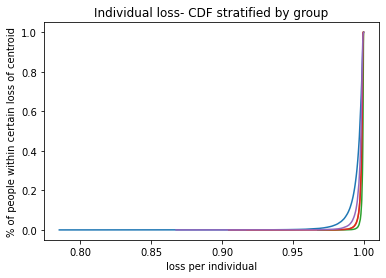

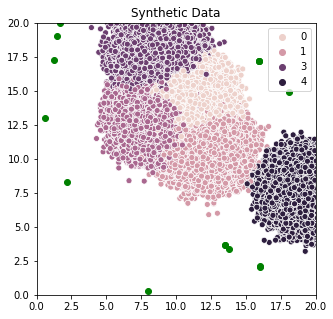

Time elapsed Batch Step:  0.4271550178527832
Time elapsed Assignment Step:  2.7296884059906006
indiv loss  0.9976250049596264
subgroup loss:  0.0022881674500075944
indiv loss  0.21511614757609496
subgroup loss:  0.0022881674500075944
iteration number:  30
old loss:  0.21647015746808027
temp loss:  0.21511614757609496


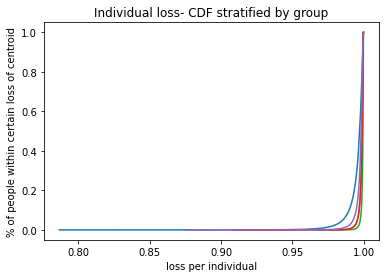

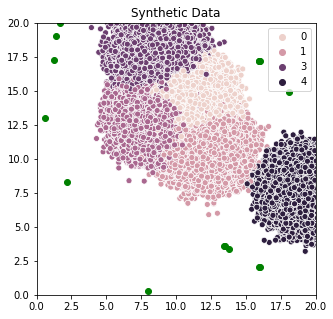

Time elapsed Batch Step:  0.43396782875061035
Time elapsed Assignment Step:  2.7663092613220215
indiv loss  0.9976791343455619
subgroup loss:  0.0022635161694672945
indiv loss  0.2127868778831587
subgroup loss:  0.0022635161694672945
iteration number:  31
old loss:  0.21511614757609496
temp loss:  0.2127868778831587


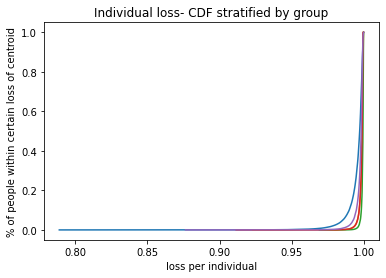

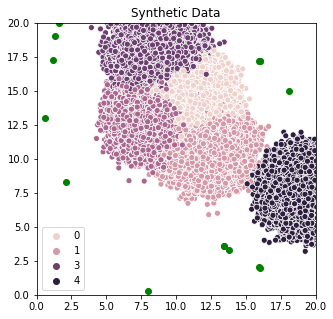

Time elapsed Batch Step:  0.42074108123779297
Time elapsed Assignment Step:  2.7994801998138428
indiv loss  0.9977922503564516
subgroup loss:  0.0021158681709079197
indiv loss  0.20249778903063945
subgroup loss:  0.0021158681709079197
iteration number:  32
old loss:  0.2127868778831587
temp loss:  0.20249778903063945


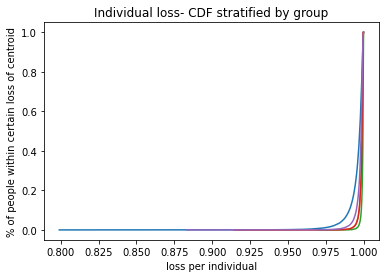

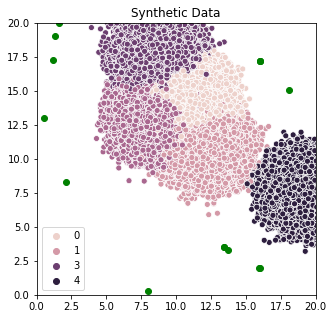

Time elapsed Batch Step:  0.43544507026672363
Time elapsed Assignment Step:  2.75616455078125
indiv loss  0.997833318202984
subgroup loss:  0.002111116551282821
indiv loss  0.20138706816148247
subgroup loss:  0.002111116551282821
iteration number:  33
old loss:  0.20249778903063945
temp loss:  0.20138706816148247


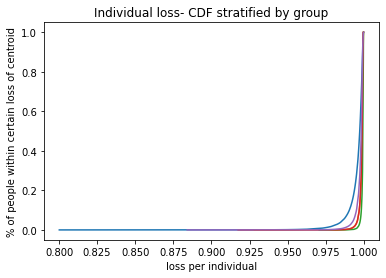

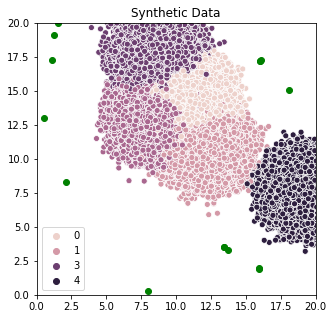

Time elapsed Batch Step:  0.43602514266967773
Time elapsed Assignment Step:  2.78676176071167
indiv loss  0.9978848404078093
subgroup loss:  0.002090520906601445
indiv loss  0.19935754416222753
subgroup loss:  0.002090520906601445
iteration number:  34
old loss:  0.20138706816148247
temp loss:  0.19935754416222753


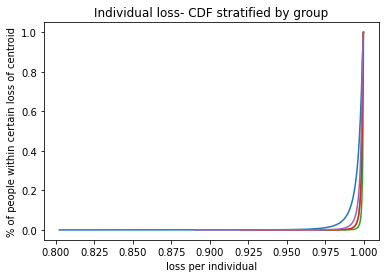

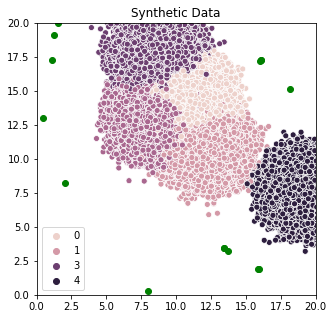

Time elapsed Batch Step:  0.4159419536590576
Time elapsed Assignment Step:  2.7502284049987793
indiv loss  0.9979725497524508
subgroup loss:  0.0019614349846279744
indiv loss  0.19011189052004324
subgroup loss:  0.0019614349846279744
iteration number:  35
old loss:  0.19935754416222753
temp loss:  0.19011189052004324


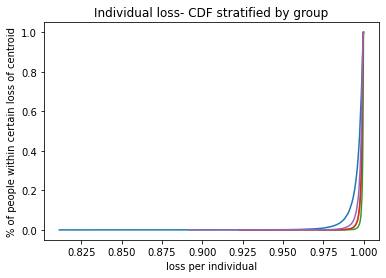

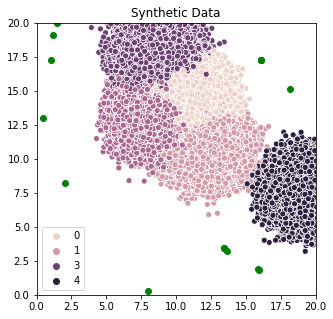

Time elapsed Batch Step:  0.43284177780151367
Time elapsed Assignment Step:  2.772855758666992
indiv loss  0.998011656943901
subgroup loss:  0.001957863249861247
indiv loss  0.1891668651525816
subgroup loss:  0.001957863249861247
iteration number:  36
old loss:  0.19011189052004324
temp loss:  0.1891668651525816


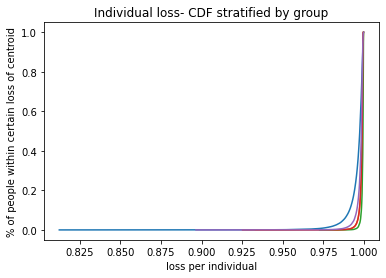

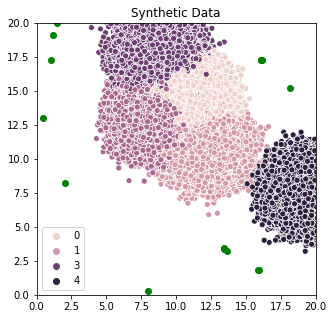

Time elapsed Batch Step:  0.4299190044403076
Time elapsed Assignment Step:  2.7726826667785645
indiv loss  0.9980459830746009
subgroup loss:  0.0019397477901230697
indiv loss  0.18736479685267582
subgroup loss:  0.0019397477901230697
iteration number:  37
old loss:  0.1891668651525816
temp loss:  0.18736479685267582


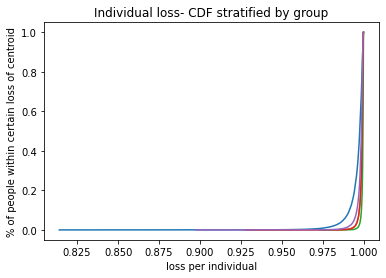

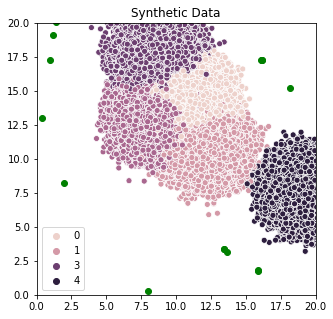

Time elapsed Batch Step:  0.42354321479797363
Time elapsed Assignment Step:  2.816521644592285
indiv loss  0.9981340181674974
subgroup loss:  0.0018265405189794581
indiv loss  0.1790373417955425
subgroup loss:  0.0018265405189794581
iteration number:  38
old loss:  0.18736479685267582
temp loss:  0.1790373417955425


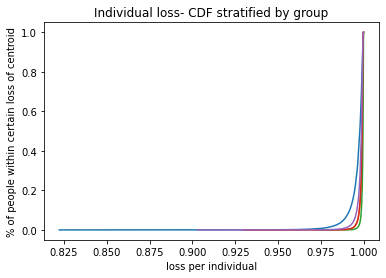

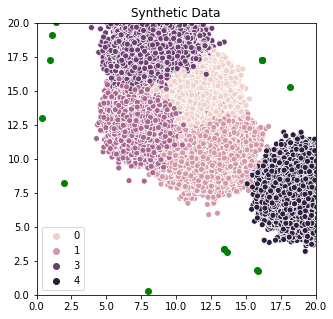

Time elapsed Batch Step:  0.4163632392883301
Time elapsed Assignment Step:  2.7481560707092285
indiv loss  0.9981656225053012
subgroup loss:  0.001823817311040088
indiv loss  0.17822055861351987
subgroup loss:  0.001823817311040088
iteration number:  39
old loss:  0.1790373417955425
temp loss:  0.17822055861351987


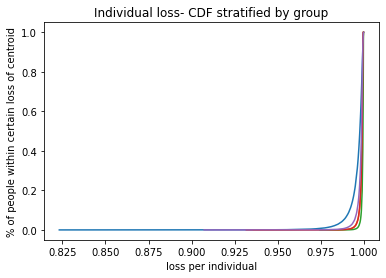

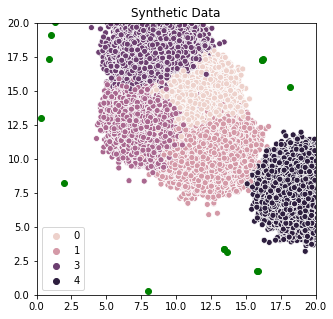

Time elapsed Batch Step:  0.4337172508239746
Time elapsed Assignment Step:  2.7554807662963867
indiv loss  0.9981960000326697
subgroup loss:  0.0018084276372769548
indiv loss  0.17661952447562335
subgroup loss:  0.0018084276372769548
iteration number:  40
old loss:  0.17822055861351987
temp loss:  0.17661952447562335


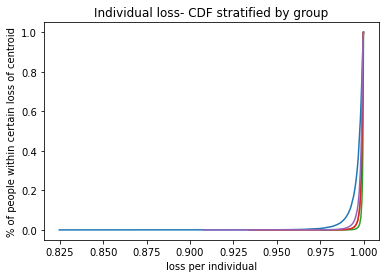

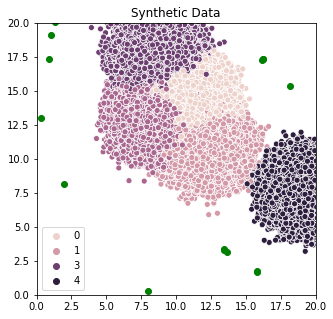

Time elapsed Batch Step:  0.4380331039428711
Time elapsed Assignment Step:  2.7487151622772217
indiv loss  0.9982675996515405
subgroup loss:  0.001708095587414138
indiv loss  0.16907505395787545
subgroup loss:  0.001708095587414138
iteration number:  41
old loss:  0.17661952447562335
temp loss:  0.16907505395787545


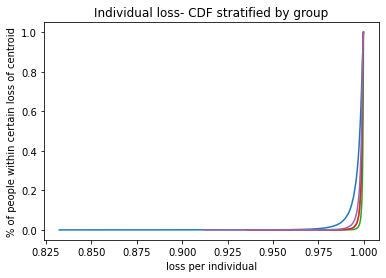

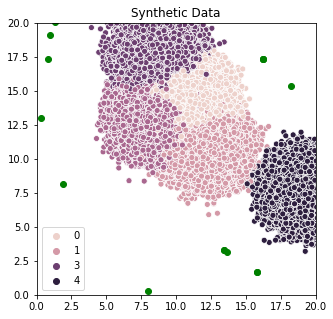

Time elapsed Batch Step:  0.4280092716217041
Time elapsed Assignment Step:  2.7136476039886475
indiv loss  0.9982904394377528
subgroup loss:  0.0017059184298795493
indiv loss  0.16835103017341949
subgroup loss:  0.0017059184298795493
iteration number:  42
old loss:  0.16907505395787545
temp loss:  0.16835103017341949


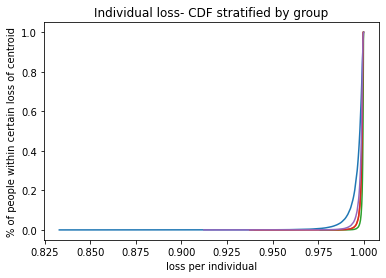

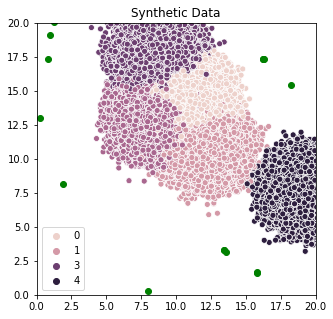

Time elapsed Batch Step:  0.423370361328125
Time elapsed Assignment Step:  2.7580056190490723
indiv loss  0.9983195742291873
subgroup loss:  0.0016926985369283276
indiv loss  0.16695562884439252
subgroup loss:  0.0016926985369283276
iteration number:  43
old loss:  0.16835103017341949
temp loss:  0.16695562884439252


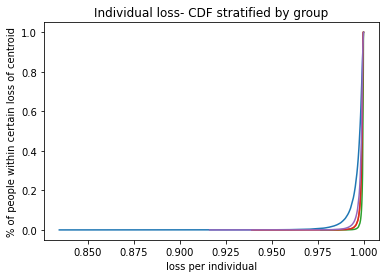

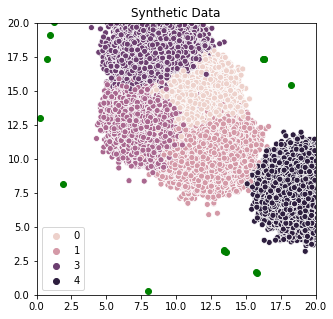

Time elapsed Batch Step:  0.4144167900085449
Time elapsed Assignment Step:  2.762437105178833
indiv loss  0.9983803826999419
subgroup loss:  0.0016028657978504057
indiv loss  0.16006290957196223
subgroup loss:  0.0016028657978504057
iteration number:  44
old loss:  0.16695562884439252
temp loss:  0.16006290957196223


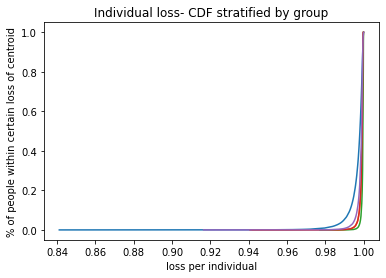

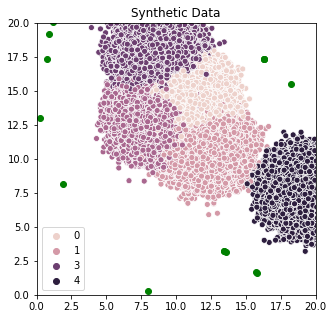

Time elapsed Batch Step:  0.4286153316497803
Time elapsed Assignment Step:  2.748889207839966
indiv loss  0.9984023931922921
subgroup loss:  0.0016012979222709278
indiv loss  0.15944805211092278
subgroup loss:  0.0016012979222709278
iteration number:  45
old loss:  0.16006290957196223
temp loss:  0.15944805211092278


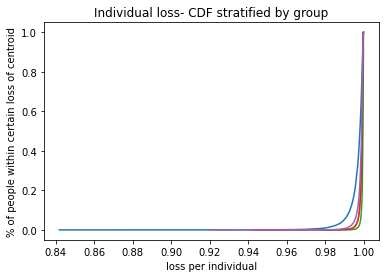

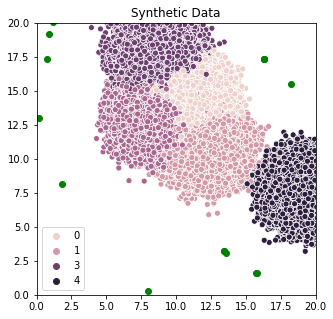

Time elapsed Batch Step:  0.4322953224182129
Time elapsed Assignment Step:  2.809932231903076
indiv loss  0.9984256278170562
subgroup loss:  0.0015898524483620724
indiv loss  0.1581829922339451
subgroup loss:  0.0015898524483620724
iteration number:  46
old loss:  0.15944805211092278
temp loss:  0.1581829922339451


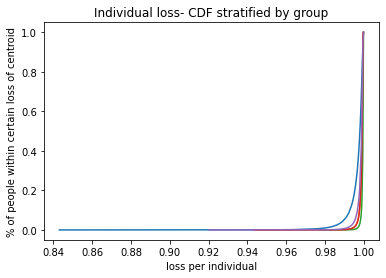

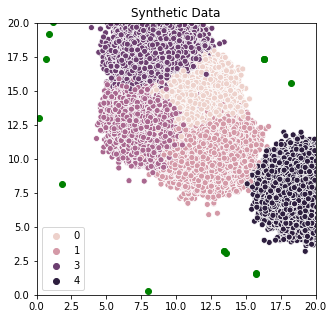

Time elapsed Batch Step:  0.43325281143188477
Time elapsed Assignment Step:  2.752680778503418
indiv loss  0.9984815691425836
subgroup loss:  0.0015092123867244123
indiv loss  0.15190482342027153
subgroup loss:  0.0015092123867244123
iteration number:  47
old loss:  0.1581829922339451
temp loss:  0.15190482342027153


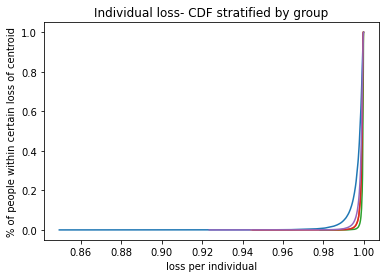

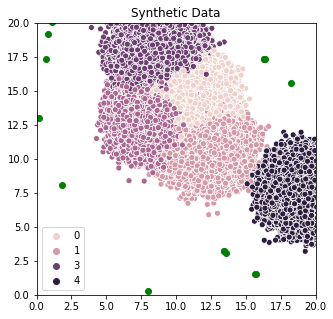

Time elapsed Batch Step:  0.4280562400817871
Time elapsed Assignment Step:  2.7660837173461914
indiv loss  0.9985063089344907
subgroup loss:  0.0014920663068682671
indiv loss  0.15019048362426263
subgroup loss:  0.0014920663068682671
iteration number:  48
old loss:  0.15190482342027153
temp loss:  0.15019048362426263


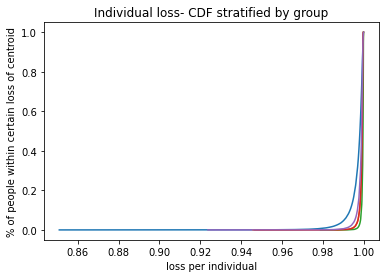

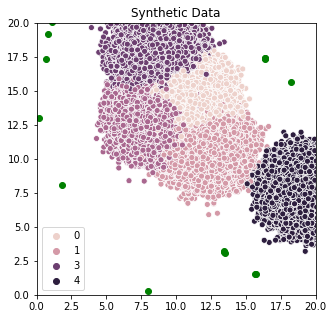

Time elapsed Batch Step:  0.4418792724609375
Time elapsed Assignment Step:  2.835942029953003
indiv loss  0.9985340007886101
subgroup loss:  0.0014702487796242059
indiv loss  0.14823074010401086
subgroup loss:  0.0014702487796242059
iteration number:  49
old loss:  0.15019048362426263
temp loss:  0.14823074010401086


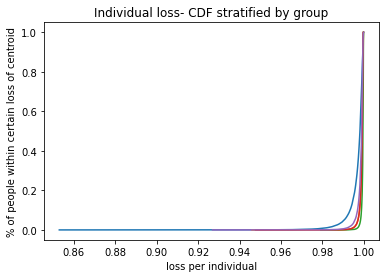

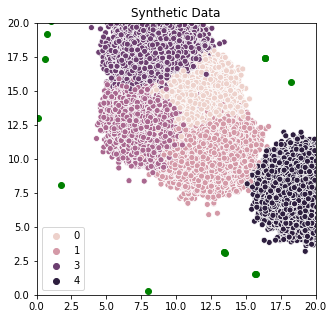

Time elapsed Batch Step:  0.41921329498291016
Time elapsed Assignment Step:  2.8032443523406982
indiv loss  0.998570225683386
subgroup loss:  0.0014252734626228891
indiv loss  0.14447635456759425
subgroup loss:  0.0014252734626228891
iteration number:  50
old loss:  0.14823074010401086
temp loss:  0.14447635456759425


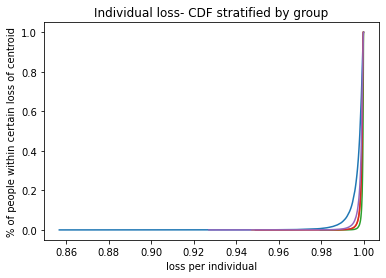

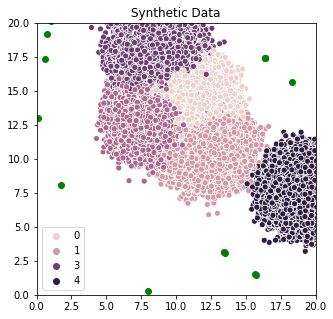

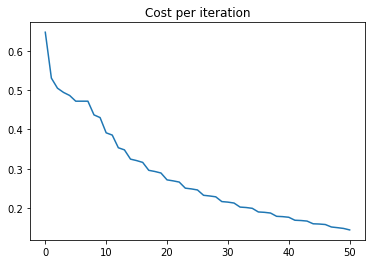

Reached max iterations


{0: (15.666345848947264, 1.5219734288559639),
 1: (1.042907196263758, 20.120387126774638),
 2: (13.455317880643847, 3.149283577316506),
 3: (16.39404644564523, 17.41341449503095),
 4: (18.275645196966302, 15.685954482769366),
 5: (0.5901720877270168, 17.364338597092544),
 6: (0.7738454447548906, 19.185807511113694),
 7: (1.755713732404799, 8.084540136583323),
 8: (16.404358475985443, 17.42579185393862),
 9: (15.698741898284705, 1.4595735449126783),
 10: (0.09523944727416436, 12.973198867407229),
 11: (16.380627221377637, 17.41153420708199),
 12: (13.517832984436804, 3.0687799749382783),
 13: (13.466597410845727, 3.156545733504108),
 14: (7.983031598981263, 0.3093717210860514)}

In [16]:
df = assign_cluster(df, centroids)
groups = compute_groups(df)
compute_cdf_graph(groups)
clusters = compute_clusters(df)
cdf1, cdf2 = compute_cdf(groups)
#subgroup loss between max and min loss
subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)
loss = sum_loss(df, centroids, subgroup_loss)
update(.7, centroids,df, subgroup_loss, loss, groups, cdf1)

In [17]:
centroids 

{0: (15.666345848947264, 1.5219734288559639),
 1: (1.042907196263758, 20.120387126774638),
 2: (13.455317880643847, 3.149283577316506),
 3: (16.39404644564523, 17.41341449503095),
 4: (18.275645196966302, 15.685954482769366),
 5: (0.5901720877270168, 17.364338597092544),
 6: (0.7738454447548906, 19.185807511113694),
 7: (1.755713732404799, 8.084540136583323),
 8: (16.404358475985443, 17.42579185393862),
 9: (15.698741898284705, 1.4595735449126783),
 10: (0.09523944727416436, 12.973198867407229),
 11: (16.380627221377637, 17.41153420708199),
 12: (13.517832984436804, 3.0687799749382783),
 13: (13.466597410845727, 3.156545733504108),
 14: (7.983031598981263, 0.3093717210860514)}